# Astronomer-focused demo of multitaper power spectrum estimation

This demo, which was presented in Section 2 of [Dodson-Robinson & Haley (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract), uses <em>Kepler</em> Q0 observations of the rotational variable star KIC 6102338 to illustrate the classical multitaper method of [Thomson (1982)](https://scholar.google.com/scholar_lookup?title=Spectrum%20estimation%20and%20harmonic%20analysis&author=D.J.%20Thomson&publication_year=1982&journal=Proc.%20IEEE&volume=70&pages=1055-1096).

For help understanding file-reading and plotting commands, check out [Julia quickstart for astronomers](https://github.com/lootie/Multitaper.jl/blob/master/Julia_quickstart/Julia_quickstart_astronomers.ipynb)

In [1]:
using Multitaper, Plots, DelimitedFiles, Statistics, StatsBase, LombScargle, 
      LaTeXStrings, FFTW

### Read data file, shift timestamps so t0 = 0

In [2]:
Kep0 = readdlm("KIC6102338_Q0_nanreplace.txt", comments=true)
BJD0 = Kep0[:,1]
flux0 = Kep0[:,2]
time0 = BJD0 .- BJD0[1]

1639-element Vector{Float64}:
  0.0
  0.020434484351426363
  0.040868868585675955
  0.061303152702748775
  0.08173753693699837
  0.10217202035710216
  0.12260630400851369
  0.143040687777102
  0.16347517119720578
  0.1839095545001328
  0.20434383768588305
  0.22477822052314878
  0.24521270347759128
  ⋮
 33.24650090187788
 33.266934865154326
 33.2873690277338
 33.3078030901961
 33.328237052541226
 33.34867121465504
 33.36910527665168
 33.38953923806548
 33.40997329959646
 33.43040746077895
 33.45084142172709
 33.471275482326746

### Plot the fluxes

This is Figure 1 of [Dodson-Robinson & Haley (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract).

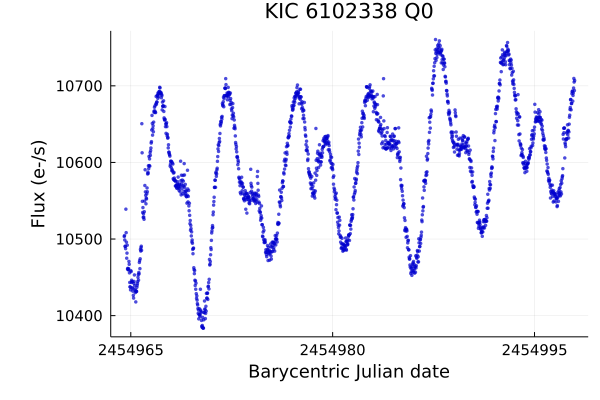

In [3]:
pflux0 = scatter(BJD0, flux0, xlabel="Barycentric Julian date", ylabel="Flux (e-/s)", 
                 legend=false, xtickfontsize=10, left_margin = 8Plots.mm, xguidefontsize=12, 
                 ytickfontsize=10, yguidefontsize=12, msw=0, title="KIC 6102338 Q0", ma=0.7, 
                 ms=2, bottom_margin = 5Plots.mm, color=:mediumblue, 
                 xticks = 2454965:15:2454995)
# savefig("KIC6102338_Q0_fluxes.png")

### Examine the timesteps

The Q0 data are very close to being evenly spaced

In [4]:
dt0 = diff(time0)
dt = median(dt0)

println(dt)
println(mean(dt0))
println(maximum(dt0))
println(minimum(dt0))

0.02043423755094409
0.020434234116194595
0.020434484351426363
0.020433489698916674


### Create a vector of scaled timestamps that have integer values t = 0, 1, 2, ..., N-1

In [5]:
tscale0 = round.(time0 ./ dt)

1639-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
   10.0
   11.0
   12.0
    ⋮
 1627.0
 1628.0
 1629.0
 1630.0
 1631.0
 1632.0
 1633.0
 1634.0
 1635.0
 1636.0
 1637.0
 1638.0

### Make a histogram of the deviations of the scaled timesteps from unity

Verify that the deviations are minimal so we can assume uniform time sampling 

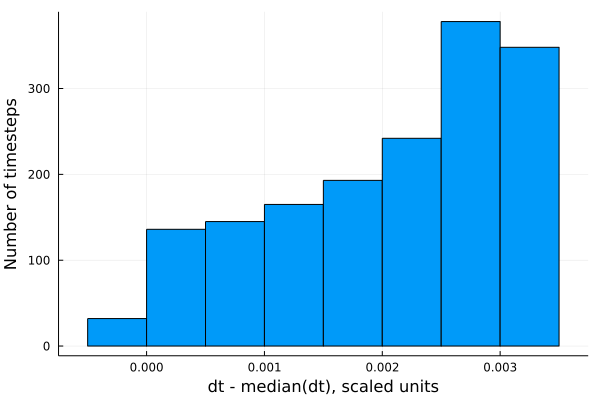

In [6]:
tscale0_check = histogram((time0 ./ dt) .- tscale0, xlabel="dt - median(dt), scaled units",
                          ylabel="Number of timesteps", label=false)

### Calculate the multitaper power spectrum estimate

Syntax of the call to <tt>multispec()</tt>:<br />
<ul>
    <li>The argument is your time series of observations. Time indices $t = 0, 1, 2, \ldots, N-1$ are not needed if there are no gaps in the time series. Technically you don't need to subtract off the mean of your time series because <tt>Multitaper.jl</tt> will do it for you, but I have deliberately ingrained the habit of zero-meaning my data anytime I'm doing Fourier analysis.</li>
    <li>If the time interval between observations is something other than 1, pass that in using the <tt>dt</tt> keyword.</li>
    <li><tt>NW</tt> is the time-bandwidth product $N\varpi$ discussed in section 2.7 of <a href="https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract">Dodson-Robinson & Haley (2024)</a>.</li>
    <li><tt>K</tt> is the number of tapers.</li>
    <li><tt>jk = true</tt> tells the software to produce confidence intervals via jackknifing (section 3.4). Jackknifing is the most computationally intensive operation performed, so if you want a quick power spectrum estimate without confidence intervals, you can turn it off with <tt>jk = false</tt>. This could be helpful if you're doing a preliminary analysis of a large dataset.</li>
    <li><tt>Ftest = true</tt> tells the software to perform the F-test for oscillations (section 3.5). Turn it off with <tt>Ftest = false</tt>.</li>
    <li><tt>pad</tt> tells the software what factor to use in padding the time-domain data / oversampling the frequency grid. The native (Rayleigh) resolution of a power spectrum estimate is $1 / (t_{N-1} - t_0)$, which gives an equal number of frequency gridpoints as observations if the time grid is evenly spaced. Your frequency grid will have length <tt>pad</tt>$\times N$. Equivalent to <tt>samples_per_peak</tt> in <tt>astropy.timeseries.LombScargle</tt>.</li>
</ul>

The output of <tt>multispec()</tt> is a structure of type <tt>MTSpectrum</tt> defined in [<tt>StructsTypes.jl</tt>](https://github.com/lootie/Multitaper.jl/blob/master/src/StructsTypes.jl). In cells 8 and 9, we directly access the structure fields for frequency (<tt>.f</tt>) and p-value given by the F-test at each frequency (<tt>.Fpval</tt>). The spectrum is in field <tt>.S</tt>.

See the [<tt>Examples</tt>](https://github.com/lootie/Multitaper.jl/blob/master/Examples/01_basic_multitaper.ipynb) directory for more power spectrum estimates.

In [7]:
NW  = 4
K   = 6
pad = 2.0
SQ0 = multispec(flux0 .- mean(flux0), dt = dt, NW = NW, K = K, jk = true, 
                Ftest = true, pad = pad)

MTSpectrum{Nothing, Vector{Float64}, Nothing}(0.0:0.01492906513848523:24.46873776197729, [4018.2068162272085, 3771.1000742874526, 3985.779742755374, 3418.5406582123283, 3345.190990616876, 4623.624667488403, 7426.263902452629, 10043.375046446274, 9781.994715865256, 10205.926673873275  …  0.6752430369173478, 0.6367643857107913, 0.6200827652582567, 0.6307558094535879, 0.6205976115361367, 0.6611442996616258, 0.5034516811028784, 0.42843085459695857, 0.4931149555605381, 0.40069148627497836], nothing, MTParameters(4.0, 6, 1639, 0.02043423755094409, 3278, 1, nothing), nothing, [0.9842102134041083, 0.07409981581336011, 0.05609776795977761, 0.8437292328507815, 0.5064191583775336, 0.5896042828804456, 0.9710944855443747, 0.8007965735595506, 0.9305028859656708, 0.8657775256832873  …  0.43106935804779356, 0.5520774273809622, 0.133871466073348, 0.3516762915169993, 0.5188690100547616, 0.2137509548937625, 0.19216795360655292, 0.46042014398911923, 0.802733440584222, 0.9714371935246392], [0.4330561916579

### Identify the peaks significant at 1-1/N level (1/N FAP)

With a false alarm probability threshold of 1/N, we expect roughly 1 F-test false alarm per power spectrum estimate. This is the stringent criterion recommended by [Thomson (1990)](https://ui.adsabs.harvard.edu/abs/1990RSPTA.332..539T/abstract).

In [8]:
N = length(time0)
threshold = 1 / N
SQ0Pks = findall(SQ0.Fpval .< threshold)

2-element Vector{Int64}:
 14
 27

### Plot the multitaper power spectrum estimate across all frequencies

<tt>Multitaper.jl</tt> has a [plot recipe](http://juliaplots.org/RecipesBase.jl/dev/) for structures of type <tt>MTSpectrum</tt>. It automatically overlays the confidence interval on the power spectrum estimate.

This plot is going to be the topmost in a stack of three. I overwrite the default x axis label from the plot recipe because I want the x label to appear on the bottom plot only. Green dots denote statistically significant oscillations identified in the cell above.

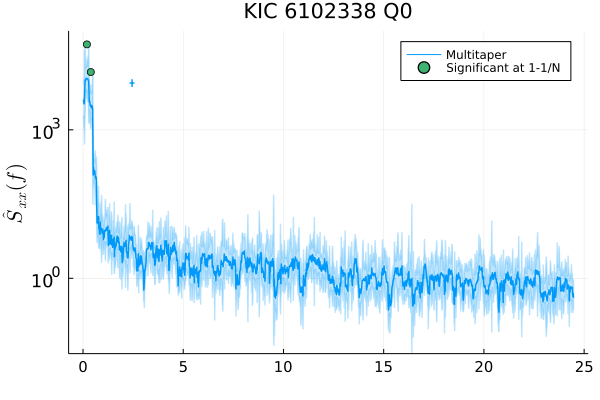

In [9]:
Q0specplot = plot(SQ0, ylabel=L"\hat{S}_{xx}(f)", label="Multitaper", title="KIC 6102338 Q0", 
                  lw=1.5, xtickfontsize=10, ytickfontsize=12, yguidefontsize=14, 
                  legendfontsize=8, xlabel=" ", ylim=(0.03,1e5))

# Annotate the statistically significant oscillations
scatter!(SQ0.f[SQ0Pks], 5 .* SQ0.S[SQ0Pks], color=:mediumseagreen, 
         label="Significant at 1-1/N")

### Plot the F test p-values and annotate significant signals

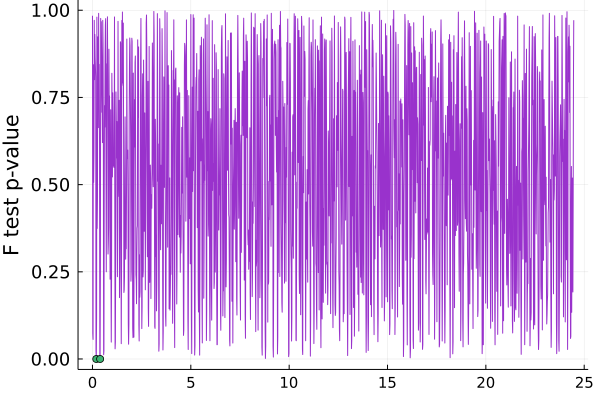

In [10]:
Fplot = plot(SQ0.f, SQ0.Fpval, ylabel="F test p-value", xtickfontsize=10, 
             ytickfontsize=12, yguidefontsize=14, label=false, color=:darkorchid,
             top_margin=-4Plots.mm)

scatter!(SQ0.f[SQ0Pks], SQ0.Fpval[SQ0Pks], color=:mediumseagreen, label=false)

### Compute the Schuster periodogram

We add zeros to the end of the time series to make a series with length 2N (zero padding).  In doing so, we oversample the frequency domain by a factor of 2, just as in our call to <tt>multispec()</tt>.

In [11]:
N        = length(time0)
M        = 2*N
halffreq = Int64(M/2+1)
freq0    = LinRange(0, 1, M+1)[1:halffreq] ./ dt
fluxfft  = fft((1/sqrt(M)) .* vcat(flux0 .- mean(flux0), zeros(M-N))) # Fourier coefficients
pgram    = abs2.(fluxfft) ./ (N * dt)

3278-element Vector{Float64}:
     1.9592145666331302e-24
  9815.095954786466
  6461.825392683617
    50.304882795734315
  1862.464505606779
   486.2776684385568
   184.2881416569807
    95.6316670458055
   336.0402532351837
   343.354661064837
  1470.127270640206
   562.7832634002335
 22685.408250436347
     ⋮
 22685.40825043634
   562.7832634002337
  1470.1272706402065
   343.3546610648368
   336.0402532351843
    95.63166704580564
   184.28814165698077
   486.2776684385568
  1862.464505606779
    50.30488279573447
  6461.825392683614
  9815.09595478646

### Plot the multitaper confidence intervals with Schuster periodogram on top

The y-axis scaling is designed for the combined figure, which will zoom in on the low frequencies (0-6 cycles/day). Multitaper confidence intervals are plotted using the same recipe as in cell 9. Setting a thin linewidth with <tt>lw=0.2</tt> prevents the multitaper power spectrum estimate from showing up.

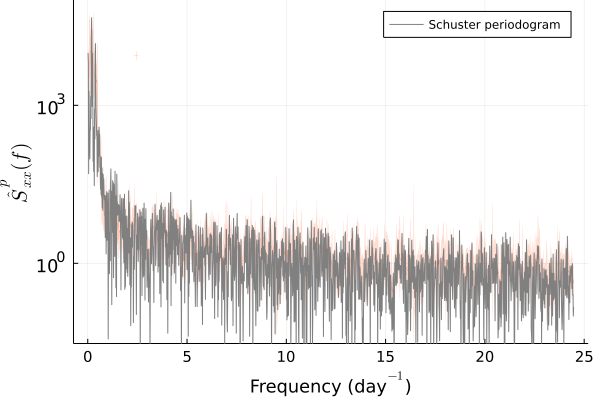

In [12]:
perplot = plot(SQ0, xlabel="Frequency (day"*L"^{-1}"*")", ylabel=L"\hat{S}^p_{xx}(f)", 
               lw=0.2, xtickfontsize=10, ytickfontsize=12, xguidefontsize=12, 
               yguidefontsize=14, legendfontsize=8, bottom_margin=3Plots.mm,
               color=:coral, label=false, ylim=(0.03,1e5), top_margin=-4Plots.mm)

plot!(freq0[2:halffreq], pgram[2:halffreq], color=:gray, 
      label="Schuster periodogram", yscale=:log10)

### Combine the three plots into one figure, zoom in on low frequencies

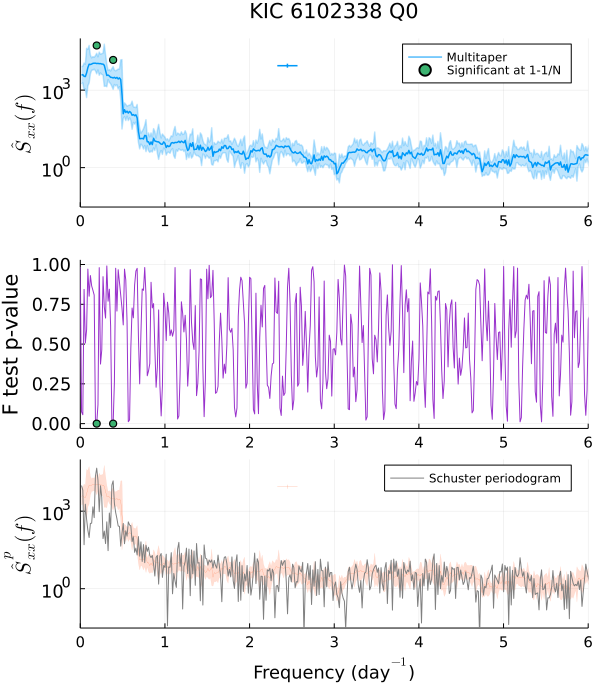

In [13]:
plot(Q0specplot, Fplot, perplot, layout=(3,1), wsize=(600,700), xlim=(0,6))
# savefig("KIC6102338_Q0_spec.png")

In [14]:
println("p-value threshold for significance: $(threshold)")
println("Corresponding statistical significance level: $(1-threshold)")

p-value threshold for significance: 0.0006101281269066504
Corresponding statistical significance level: 0.9993898718730934
